# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.071971,True,6.350587
1,2.246096,True,10.096134
2,1.069176,True,7.397987
3,1.224462,True,6.654648
4,1.755276,True,8.642783
...,...,...,...
995,0.726234,True,5.903797
996,0.344644,True,6.034856
997,-0.660465,True,4.843112
998,0.452715,True,4.591689


<Axes: xlabel='v0'>

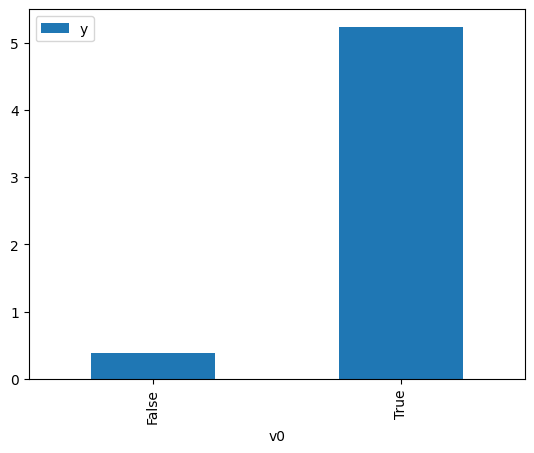

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

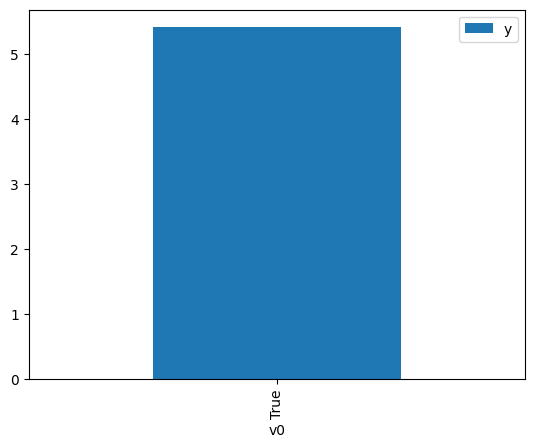

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.910662,False,1.367706,0.279426,3.578769
1,-0.670775,False,-1.656667,0.652701,1.532096
2,1.616552,False,3.621315,0.160869,6.216236
3,-0.054806,False,0.375146,0.504052,1.983924
4,1.179722,False,2.520427,0.228671,4.373089
...,...,...,...,...,...
995,0.893575,False,0.601578,0.282872,3.535168
996,0.208762,False,-0.121676,0.438604,2.279961
997,1.376052,False,2.880303,0.195956,5.103178
998,-0.696526,False,-0.548249,0.658503,1.518596


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.082164,True,2.275158,0.260863,3.833433
1,-0.898633,True,2.081847,0.297689,3.359216
2,-1.582570,True,1.347511,0.176407,5.668721
3,0.192104,True,5.449098,0.557298,1.794371
4,-0.069426,True,4.934055,0.492301,2.031276
...,...,...,...,...,...
995,0.381429,True,4.719965,0.603279,1.657607
996,1.408652,True,6.522314,0.809119,1.235912
997,2.215378,True,8.554662,0.904598,1.105463
998,-0.265296,True,4.177513,0.443672,2.253915


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.959
Model:                            OLS   Adj. R-squared (uncentered):              0.959
Method:                 Least Squares   F-statistic:                          1.161e+04
Date:                Mon, 26 Jan 2026   Prob (F-statistic):                        0.00
Time:                        20:54:50   Log-Likelihood:                         -1402.2
No. Observations:                1000   AIC:                                      2808.
Df Residuals:                     998   BIC:                                      2818.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.7551      0.034     50.952      0.000       1.688       1.823
x2             5.0362      0.046    108.819      0.000       4.945       5.127
==============================================================================
Omnibus:                        0.184   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.912   Jarque-Bera (JB):                0.267
Skew:                           0.001   Prob(JB):                        0.875
Kurtosis:                       2.920   Cond. No.                         1.72
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""